<a href="https://colab.research.google.com/github/ustha07/Portfolio_Project_Multiclass_Text_Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [98]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import torch
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from plotly import graph_objects as go
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from lime import lime_tabular
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report

# Importing Datasets

### Banking Classification

In [6]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train_banking = pd.read_parquet("hf://datasets/legacy-datasets/banking77/" + splits["train"])
df_test_banking = pd.read_parquet("hf://datasets/legacy-datasets/banking77/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
num_classes = df_train_banking['label'].nunique()

# Preparing the dataset: Banking

In [21]:
classification_task = 'banking'

In [22]:
df_train = df_train_banking
df_test = df_test_banking

In [23]:
df_train, df_val = train_test_split(df_train, test_size=0.3, random_state = 42, stratify = df_train['label'])

#### Variables

In [24]:
num_classes = df_train['label'].nunique()
sample_proportion = 0.6
sample_proportion_test = 0.2
batch_size = 100

### EDA

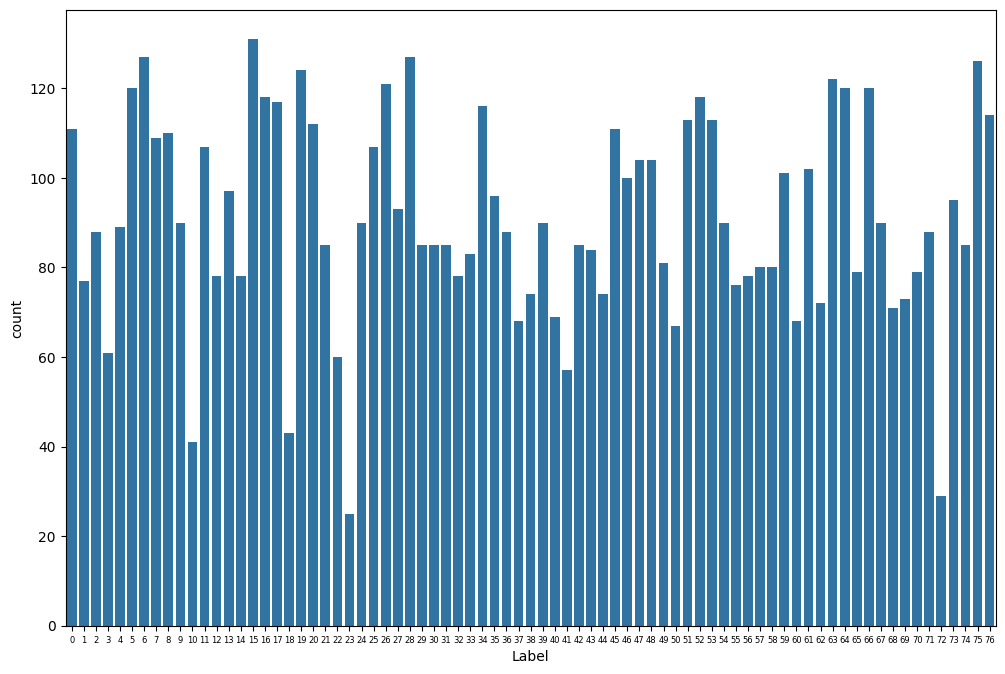

In [25]:
labels = df_train['label'].value_counts().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(labels, x = 'label', y = 'count')
plt.xlabel("Label")
plt.xticks(fontsize=6)
plt.show()

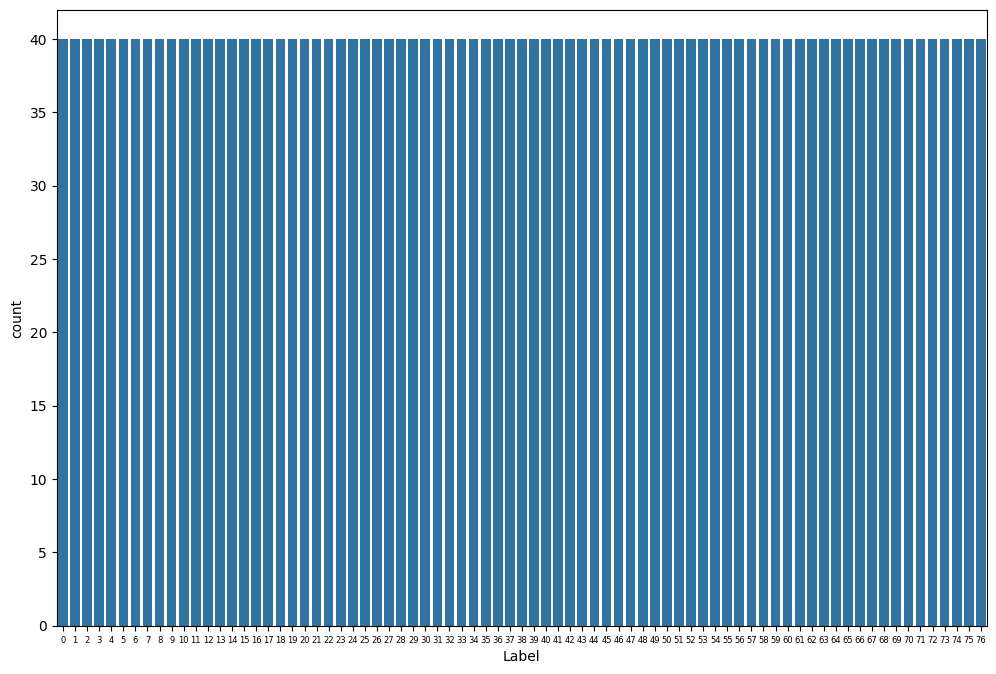

In [26]:
labels = df_test['label'].value_counts().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(labels, x = 'label', y = 'count')
plt.xlabel("Label")
plt.xticks(fontsize=6)
plt.show()

### Sampling

#### Splitting the training dataset into training and validation sets

In [27]:
df_train_sampled, df_val_sampled = train_test_split(df_train, test_size=0.2, random_state=42, stratify = df_train['label'])

#### Sampling from all datasets

In [28]:
df_train_sampled = df_train_sampled.groupby('label').sample(frac = sample_proportion, random_state = 42)
df_test_sampled = df_test.groupby('label').sample(frac = sample_proportion/2, random_state = 42)
df_val_sampled = df_val_sampled.groupby('label').sample(frac = sample_proportion, random_state = 42)

In [29]:
original_distribution = df_train['label'].value_counts(normalize = True)
stratified_distribution = df_train_sampled['label'].value_counts(normalize = True)
print("Oiginal Distribution:", original_distribution)
print("Stratified Distribution:", stratified_distribution)

Oiginal Distribution: label
15    0.018709
6     0.018138
28    0.018138
75    0.017995
19    0.017709
        ...   
41    0.008141
18    0.006141
10    0.005855
72    0.004142
23    0.003570
Name: proportion, Length: 77, dtype: float64
Stratified Distribution: label
15    0.018720
75    0.018039
6     0.018039
28    0.018039
19    0.017699
        ...   
41    0.008169
18    0.006127
10    0.005786
72    0.004084
23    0.003404
Name: proportion, Length: 77, dtype: float64


In [30]:
df_train_sampled.shape, df_val_sampled.shape, df_test_sampled.shape

((2938, 2), (1263, 2), (924, 2))

# Bert

#### Initializing TFBertModel and BertTokenizer

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')
model.trainable = False

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

#### Converting the texts from the dataframes into lists

In [32]:
texts_train = df_train_sampled['text'].tolist()
texts_val = df_val_sampled['text'].tolist()
texts_test = df_test_sampled['text'].tolist()

### CLS Embeddings for the different sets [test, train, validation]

In [33]:
length = len(df_train_sampled)

#### Function to generate bert embeddings

In [34]:
def get_embeddings(texts):
    length = len(texts)
    n_batches = length // batch_size + (length % batch_size != 0)

    inputs = tokenizer(texts, return_tensors = 'tf', padding = True, truncation = True, add_special_tokens = True)
    cls_embeddings = []

    for i in range(n_batches):
        batch = inputs[i * batch_size : (i + 1) * batch_size]
        outputs = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
        last_hidden_state = outputs.last_hidden_state
        cls_embedding = last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_embedding)
    return cls_embeddings

#### Generating the embeddings

In [35]:
cls_train = get_embeddings(texts_train)
cls_val = get_embeddings(texts_val)
cls_test = get_embeddings(texts_test)

In [36]:
x_train = tf.concat(cls_train, axis = 0)
x_val = tf.concat(cls_val, axis = 0)
x_test = tf.concat(cls_test, axis = 0)

#### Specifying y values

In [37]:
y_train = df_train_sampled['label']
y_val = df_val_sampled['label']
y_test = df_test_sampled['label']

In [38]:
x_train.shape, x_val.shape, x_test.shape

(TensorShape([2938, 768]), TensorShape([1263, 768]), TensorShape([924, 768]))

In [39]:
y_train.shape, y_val.shape, y_test.shape

((2938,), (1263,), (924,))

# Model Training

#### Creating the model

In [131]:
ml_model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(64, activation = "relu"),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer=l2(0.01)),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(256, activation = "relu", kernel_regularizer=l2(0.01)),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(num_classes, activation = "softmax")
])

#### Compiling the model and defining the appropirate optimizer, loss function, and metric

In [132]:
ml_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
            )

#### Defining the criteria for early stopping to prevent overfitting

In [133]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.001,
                               patience = 5,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)

#### Fitting the model on the training set

In [144]:
history = ml_model.fit(x_train, y_train, batch_size = 64, epochs = 512, validation_data = (x_val, y_val),  callbacks = [early_stopping])

Epoch 1/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7095 - loss: 1.2979 - val_accuracy: 0.6580 - val_loss: 1.5348
Epoch 2/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7062 - loss: 1.3094 - val_accuracy: 0.6556 - val_loss: 1.5366
Epoch 3/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7020 - loss: 1.3476 - val_accuracy: 0.6643 - val_loss: 1.5420
Epoch 4/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7097 - loss: 1.3112 - val_accuracy: 0.6611 - val_loss: 1.5317
Epoch 5/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7035 - loss: 1.3398 - val_accuracy: 0.6643 - val_loss: 1.5307
Epoch 6/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7116 - loss: 1.3141 - val_accuracy: 0.6659 - val_loss: 1.5286
Epoch 7/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7203 - loss: 1.3013 - val_accuracy: 0.6635 - val_loss: 1.5314
Epoch 8/512
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7079 - loss: 1.3098 - val_accuracy: 0.6595 

#### Evaluating the model

In [138]:
ml_model.evaluate(x_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6430 - loss: 1.6936


[1.7021121978759766, 0.6255411505699158]

## Visualizing the model performance

#### Defining the function to plot model performance

In [139]:
def plot_model_performance(history, metric_type, start, end):
    plt.plot(history.history[f'{metric_type}'], label = f"Training {metric_type}")
    plt.plot(history.history[f'val_{metric_type}'], label = f"Validation {metric_type}")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric_type} score")
    plt.title(f"Model Performance - {metric_type}")
    plt.xlim(start, end)
    plt.legend()
    plt.show()

#### Plotting model accuracy and loss

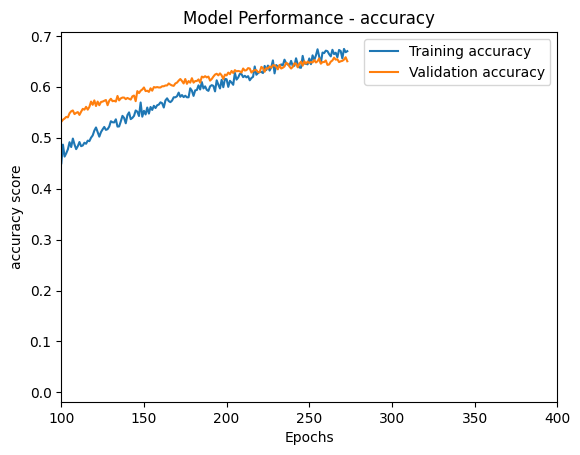

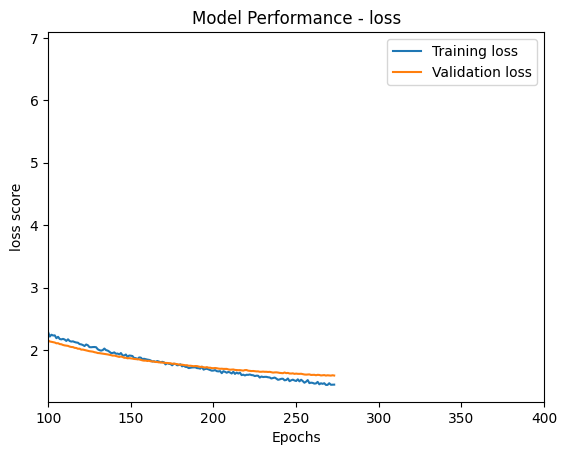

In [140]:
plot_model_performance(history, 'accuracy', 100, 400)
plot_model_performance(history, "loss", 100, 400)

# Clustering

## Heirarchichal Clustering

In [69]:
x_train.shape, x_val.shape, x_test.shape

(TensorShape([2938, 768]), TensorShape([1263, 768]), TensorShape([924, 768]))

#### Performing the clustering using the ward method and assigning the clusters in the original dataframes

In [70]:
x_combined = np.vstack([x_train, x_val, x_test])
z = linkage(x_combined, 'ward')
num_clusters = z.shape[1]
clusters = fcluster(z, num_clusters, criterion = 'maxclust') - 1
print(clusters.shape)
df_train_sampled["cluster"] = clusters[:len(x_train)]
df_val_sampled["cluster"] = clusters[len(x_train):len(x_train) + len(x_val)]
df_test_sampled["cluster"] = clusters[len(x_train)+len(x_val):len(x_train) + len(x_val) + len(x_test)]

(5125,)


#### Specifying the y-values (corresponding clusters)

In [71]:
y_train_clusters = df_train_sampled["cluster"]
y_test_clusters = df_test_sampled["cluster"]
y_val_clusters = df_val_sampled["cluster"]

In [72]:
df_test_sampled.shape

(924, 3)

In [73]:
y_test_clusters.shape

(924,)

In [74]:
df_train_sampled.shape

(2938, 3)

## PCA - Visualizing the clusters

#### PCA function

In [75]:
def pca(n):
    pca = PCA(n_components = n)
    x_pca_train = pca.fit_transform(x_train)
    x_pca_val = pca.fit_transform(x_val)
    x_pca_test = pca.fit_transform(x_test)
    return x_pca_train, x_pca_val, x_pca_test

In [76]:
x_pca_train, x_pca_val, x_pca_test = pca(2)

#### Plotting the PCA on 2D

In [77]:
def plot_2D(data, label, plot, title):
    plot.scatter(data[:, 0], data[:, 1], c = label, cmap = 'viridis')
    plot.set_title(f"Clustering the {title}")
    plot.set_xlabel("First Principal Component")
    plot.set_ylabel("Second Principal Component")

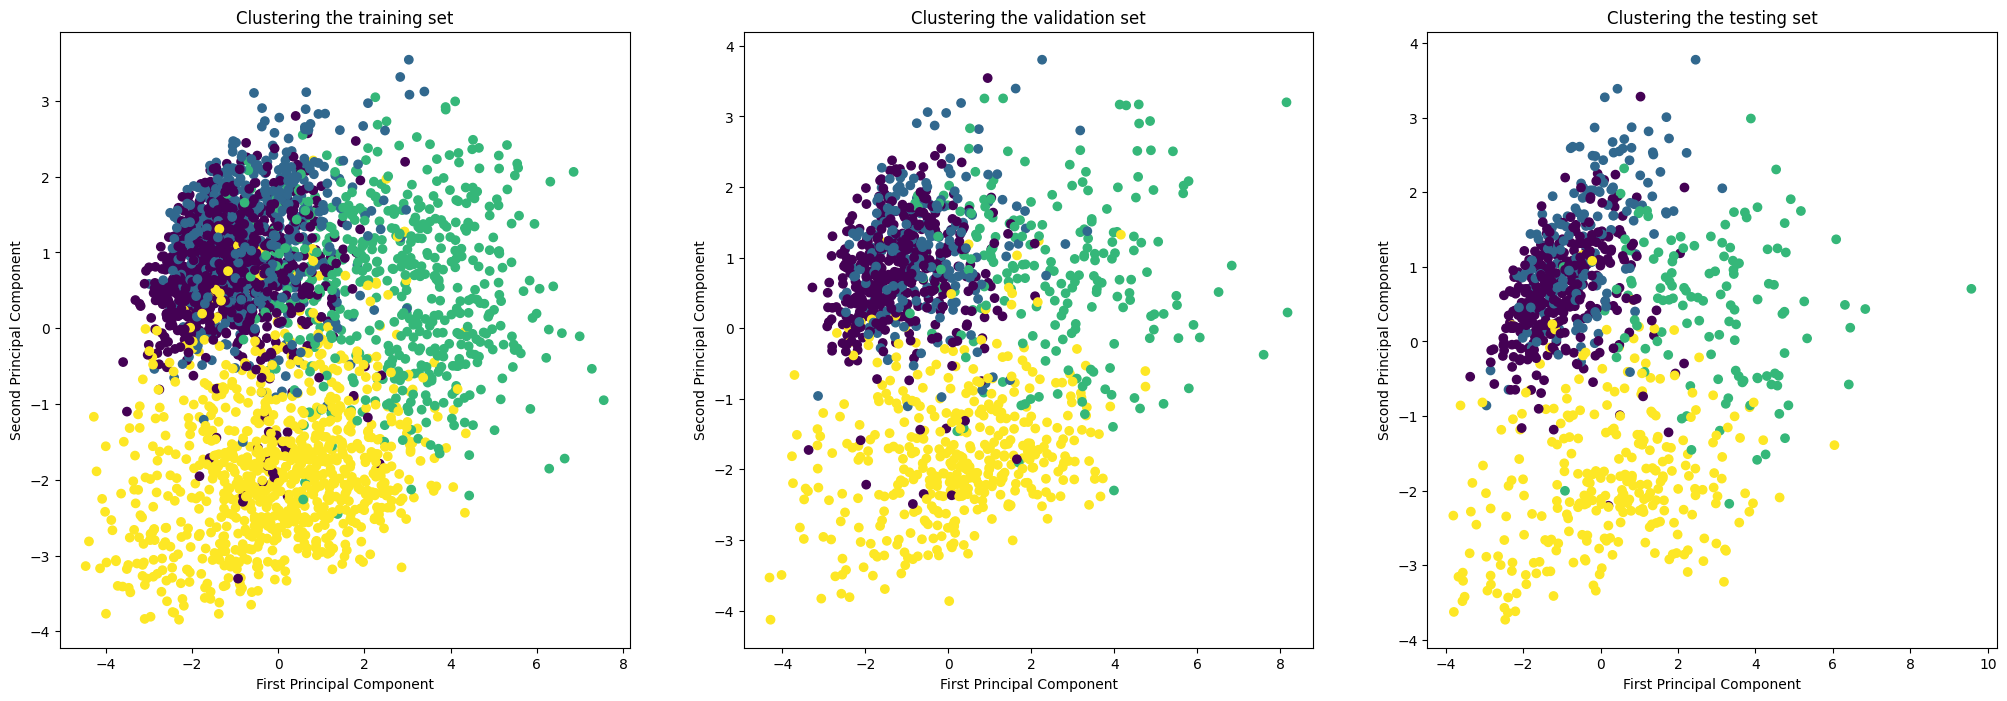

In [78]:
fig, plots = plt.subplots(1, 3, figsize = (25, 8))

plot_2D(x_pca_train, y_train_clusters, plots[0], "training set")
plot_2D(x_pca_val, y_val_clusters, plots[1], "validation set")
plot_2D(x_pca_test, y_test_clusters, plots[2], "testing set")

plt.show()

#### Plotting the PCA on 3D

In [79]:
x_pca_train, x_pca_val, x_pca_test = pca(3)

In [120]:
def plot_3D(data, label, title):
    fig = plt.figure()
    plot = fig.add_subplot(111, projection='3d')
    plot.scatter(data[:, 0], data[:, 1], data[:, 2], c = label, cmap = 'viridis')
    plot.set_title(f"PCA 3D: {title}")
    plt.show()

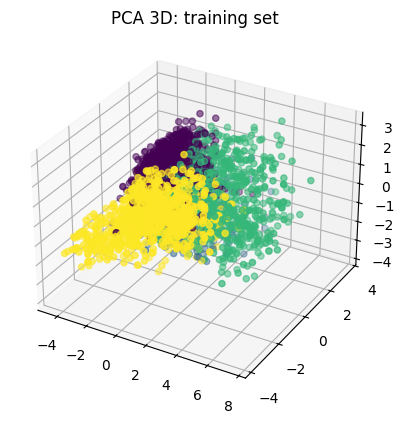

In [135]:
plot_3D(x_pca_train, y_train_clusters, "training set")

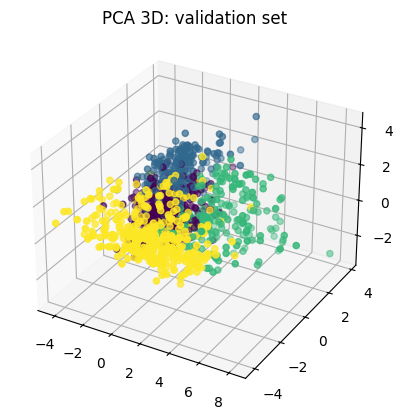

In [136]:
plot_3D(x_pca_val, y_val_clusters, "validation set")

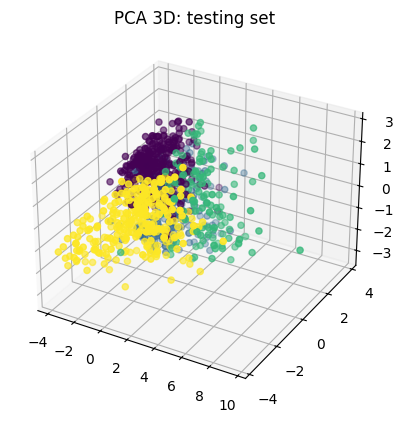

In [137]:
plot_3D(x_pca_test, y_test_clusters, "testing set")

## Model Training

#### Building the model to classify the clusters

In [86]:
model2 = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation = "relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation = "relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation = "relu"),
            tf.keras.layers.Dense(num_clusters, activation = "softmax")
])

#### Compiling the model with the appropriate optimizer, loss function, and metric

In [87]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [88]:
early_stopping = EarlyStopping(
                               monitor='val_loss',
                               min_delta = 0.001,
                               patience = 5,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True
                               )

#### Fitting the model on the training set

In [89]:
history2 = model2.fit(x_train, y_train_clusters, batch_size = 64, epochs = 64, validation_data = (x_val, y_val_clusters), callbacks = [early_stopping])

Epoch 1/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5673 - loss: 1.0392 - val_accuracy: 0.8709 - val_loss: 0.3760
Epoch 2/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8488 - loss: 0.4117 - val_accuracy: 0.8765 - val_loss: 0.3433
Epoch 3/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8781 - loss: 0.3439 - val_accuracy: 0.8947 - val_loss: 0.3023
Epoch 4/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9015 - loss: 0.2851 - val_accuracy: 0.8899 - val_loss: 0.3011
Epoch 5/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9011 - loss: 0.2584 - val_accuracy: 0.9010 - val_loss: 0.2696
Epoch 6/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9222 - loss: 0.2387 - val_accuracy: 0.9074 - val_loss: 0.2740
Epoch 7/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9061 - loss: 0.2481 - val_accuracy: 0.9042 - val_loss: 0.2855
Epoch 8/64
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9296 - loss: 0.2080 - val_accuracy: 0.9026 - val_l

#### Evaluating the model

In [90]:
model2.evaluate(x_test, y_test_clusters)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9204 - loss: 0.1826


[0.19972367584705353, 0.9199134111404419]

#### Plotting model accuracy and loss

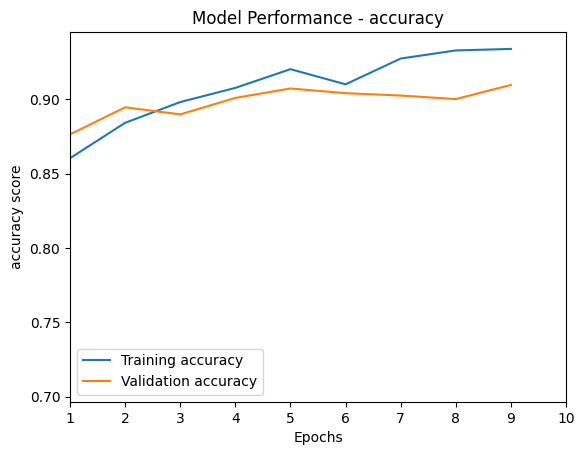

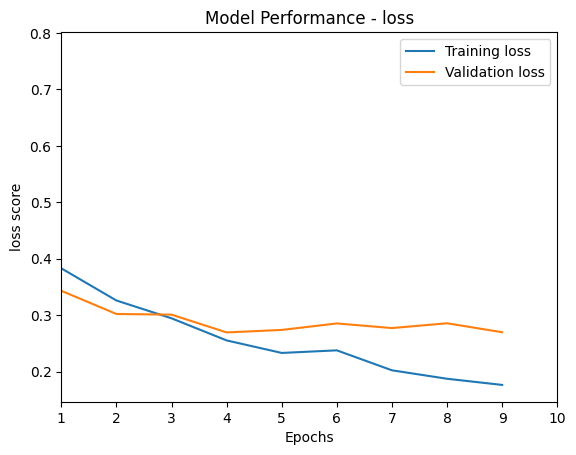

In [92]:
plot_model_performance(history2, "accuracy", 1, 10)
plot_model_performance(history2, "loss", 1, 10)

#### Plotting the overall confusion matrix

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Text(50.722222222222214, 0.5, 'Actual Labels')

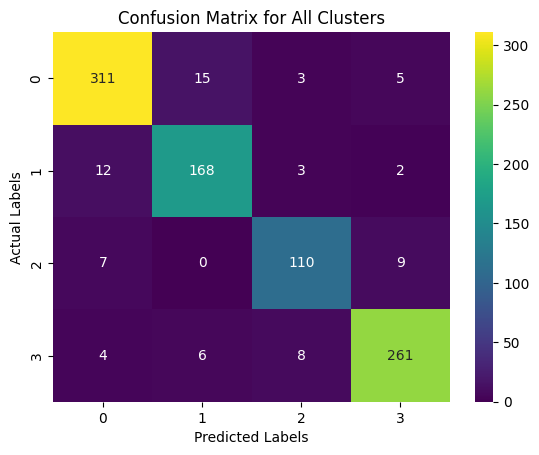

In [100]:
y_predict = model2.predict(x_test)
predicted_clusters = tf.argmax(y_predict, axis = 1)

cm = confusion_matrix(y_test_clusters, predicted_clusters)

sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'viridis')

plt.title('Confusion Matrix for All Clusters')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')


#### Plotting the individual confusion matrix for each cluster

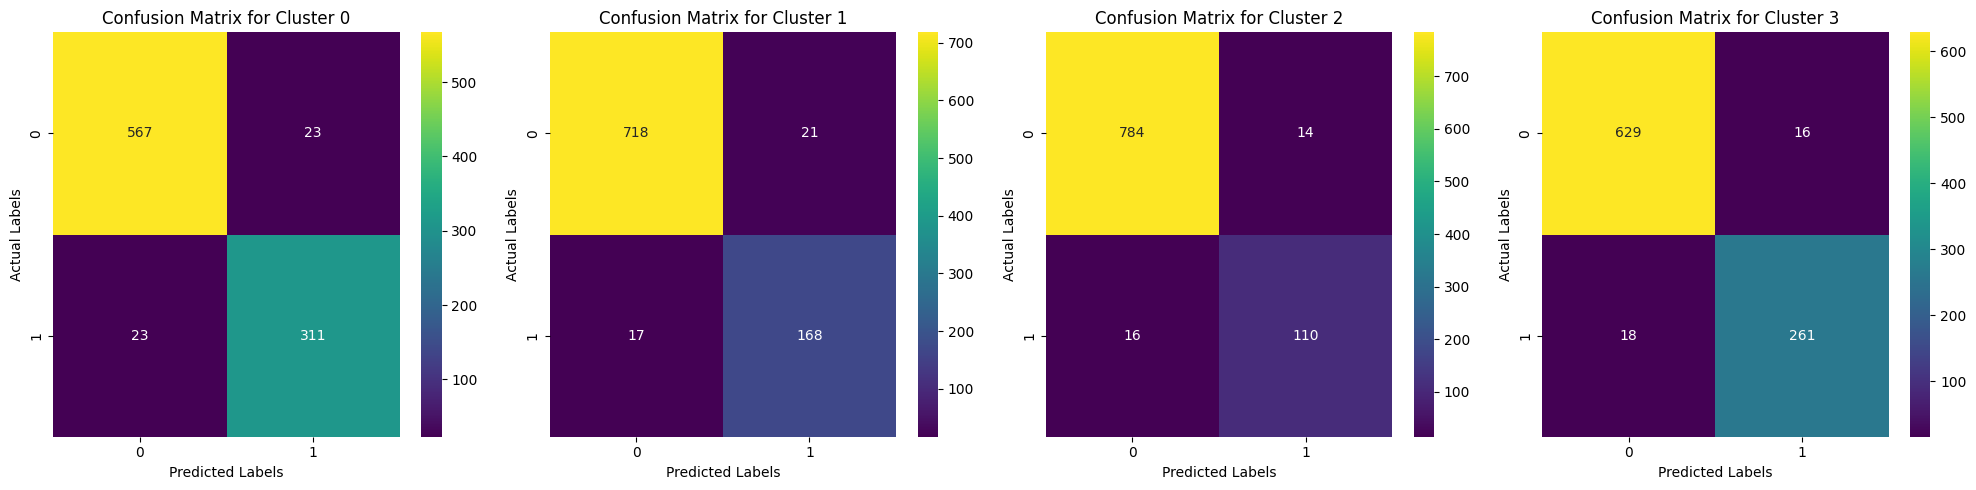

In [101]:
mcm = multilabel_confusion_matrix(y_test_clusters, predicted_clusters)

fig, plots = plt.subplots(1, 4, figsize = (20, 5))
plots = plots.flatten()
for i, cm in enumerate(mcm):
  plot = plots[i]
  sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'viridis', ax = plot)
  plot.set_title(f'Confusion Matrix for Cluster {i}')
  plot.set_xlabel('Predicted Labels')
  plot.set_ylabel('Actual Labels')

plt.tight_layout()
plt.show()

#### Classification Report

In [102]:
print(classification_report(y_test_clusters, predicted_clusters))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       334
           1       0.89      0.91      0.90       185
           2       0.89      0.87      0.88       126
           3       0.94      0.94      0.94       279

    accuracy                           0.92       924
   macro avg       0.91      0.91      0.91       924
weighted avg       0.92      0.92      0.92       924



# Classification within clusters

In [104]:
x_train_clusters = np.array(x_train)
x_test_clusters = np.array(x_test)

In [105]:
df_train_sampled

,text,label,cluster
9217,How do I turn on my new card?,0,0
9221,Can I activate my card with the app?,0,1
9234,"I am unable to activate my card, it won't let me.",0,3
9255,What is the process for activating a new card.,0,3
9271,I would like to get help from someone in your ...,0,2
...,...,...,...
8333,what are the exchange rates for foreign curren...,76,1
8314,"When I received my money, it was not in the co...",76,3
8264,what is the exchange rate when i get cash,76,3
8274,"I needed some cash while abroad, and I'm prett...",76,3


## Multinomial Naive Bayes

In [106]:
for i in range(num_clusters):
    x1 = x_train_clusters[df_train_sampled["cluster"] == i]
    y1 = df_train_sampled.loc[df_train_sampled["cluster"] == i, "label"]
    x2 = x_test_clusters[df_test_sampled["cluster"] == i]
    y2 = df_test_sampled.loc[df_test_sampled["cluster"] == i, "label"]

    scaler = MinMaxScaler()

    x1 = scaler.fit_transform(x1)
    x2 = scaler.transform(x2)

    mnb = MultinomialNB()
    mnb.fit(x1, y1)

    y_predict = mnb.predict(x2)
    accuracy = accuracy_score(y2, y_predict)

    print("Accuracy for cluster", i, ":", accuracy)

Accuracy for cluster 0 : 0.5149700598802395
Accuracy for cluster 1 : 0.5891891891891892
Accuracy for cluster 2 : 0.35714285714285715
Accuracy for cluster 3 : 0.36917562724014336


## Random Forest Classifier

In [107]:
for i in range(num_clusters):
    rf = RandomForestClassifier(n_estimators = 500)

    x1 = x_train_clusters[df_train_sampled['cluster'] == i]
    y1 = df_train_sampled.loc[df_train_sampled['cluster'] == i, "label"]
    x2 = x_test_clusters[df_test_sampled['cluster'] == i]
    y2 = df_test_sampled.loc[df_test_sampled['cluster'] == i, "label"]

    scaler = StandardScaler()
    x1 = scaler.fit_transform(x1)
    x2 = scaler.transform(x2)

    rf.fit(x1, y1)
    y_predict = rf.predict(x2)

    accuracy = accuracy_score(y2, y_predict)
    print("accuracy for cluster:", i, ":", accuracy)

accuracy for cluster: 0 : 0.5359281437125748
accuracy for cluster: 1 : 0.6108108108108108
accuracy for cluster: 2 : 0.3412698412698413
accuracy for cluster: 3 : 0.3835125448028674


## SVM

In [108]:
for i in range(num_clusters):
    sv = SVC(kernel = 'rbf')

    x1 = x_train_clusters[df_train_sampled["cluster"] == i]
    y1 = df_train_sampled.loc[df_train_sampled["cluster"] == i, "label"]
    x2 = x_test_clusters[df_test_sampled["cluster"] == i]
    y2 = df_test_sampled.loc[df_test_sampled["cluster"] == i, "label"]

    scaler = StandardScaler()
    x1 = scaler.fit_transform(x1)
    x2 = scaler.fit_transform(x2)

    sv.fit(x1, y1)
    y_predict = sv.predict(x2)

    accuracy = accuracy_score(y_predict, y2)

    print("The accuracy of cluster", i, ":", accuracy )

The accuracy of cluster 0 : 0.5568862275449101
The accuracy of cluster 1 : 0.6
The accuracy of cluster 2 : 0.35714285714285715
The accuracy of cluster 3 : 0.40860215053763443


# LIME Analysis

In [109]:
from lime import lime_tabular

#### Model Training to perform LIME Analysis

In [110]:
model3 = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(16, activation = 'relu'),
                    tf.keras.layers.Dense(num_clusters, activation = 'softmax')
])

In [111]:
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

In [112]:
model3.fit(x_train_clusters, y_train_clusters, batch_size = 16, epochs = 16, validation_data = (x_val.numpy(), y_val_clusters))

Epoch 1/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4401 - loss: 1.2400 - val_accuracy: 0.7514 - val_loss: 0.8900
Epoch 2/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7909 - loss: 0.8097 - val_accuracy: 0.8036 - val_loss: 0.6622
Epoch 3/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8143 - loss: 0.6394 - val_accuracy: 0.8385 - val_loss: 0.5528
Epoch 4/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8363 - loss: 0.5384 - val_accuracy: 0.8551 - val_loss: 0.4868
Epoch 5/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8464 - loss: 0.4713 - val_accuracy: 0.8567 - val_loss: 0.4437
Epoch 6/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8526 - loss: 0.4204 - val_accuracy: 0.8599 - val_loss: 0.4168
Epoch 7/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8714 - loss: 0.3950 - val_accuracy: 0.8638 - val_loss: 0.3947
Epoch 8/16
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8816 - loss: 0.3696 - val_accuracy: 0.

#### Initializing LIME explainer

In [114]:
array = df_train_sampled["cluster"].unique()
clusters = np.sort(array)
print(clusters)
explainer = lime_tabular.LimeTabularExplainer(
    training_data = x_train_clusters,
    feature_names = ['Feature_%d' % i for i in range(x_train.shape[1])],
    class_names = clusters,
    mode = "classification"
)

[0 1 2 3]


#### Performing LIME analysis for a test instance

In [150]:
index =  5
test_instance = x_train_clusters[index]
test_class = y_test_clusters.iloc[index]
instance = explainer.explain_instance(
    test_instance,
    model3.predict,
    labels = [test_class],
    num_features = 5,
    top_labels = 5
    )

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [151]:
instance.show_in_notebook(show_table = True, show_all = True)

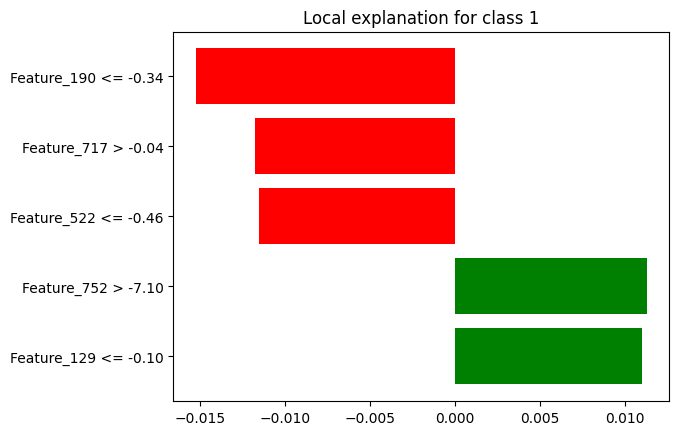

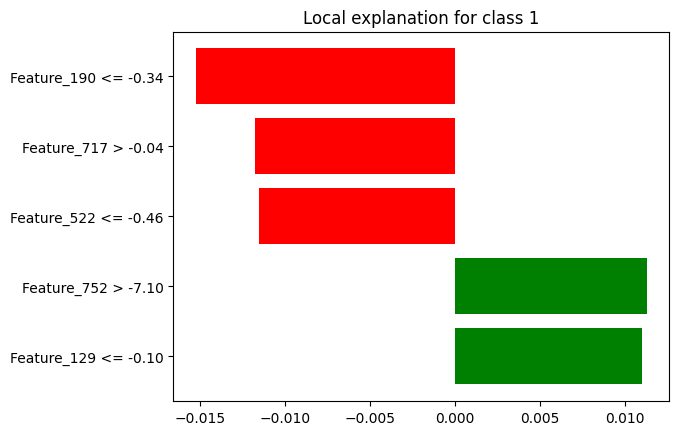

In [154]:
instance.as_pyplot_figure(label=1)